# Project 1: Regression Modeling on King County Housing Data

by: Angel Manzur, Llewellyn Jones, Filis Coba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
def r_adjusted(r_squared, X, y):
    return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

# Initial Inspection

In [3]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [4]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [6]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [7]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [8]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [9]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [10]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [11]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


# Looking for outliers

In [12]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [13]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [14]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

## Modelling whole data set

In [15]:
columns_to_drop = ['id', 'date']

In [16]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,1,1
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,0,1933,NaN,98028,47.7379,-122.233,2720,8062,0,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910,1965,0.0,98136,47.5208,-122.393,1360,5000,0,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,0


# Standardize the data

In [18]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)


In [19]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [20]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [21]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [22]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [23]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [24]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [25]:
df.drop("yr_renovated", axis=1, inplace=True)

In [27]:
#Lets select our predictor data frame
X = df.drop(columns=['price'])

In [28]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [29]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
linreg.score(X_train, y_train)

0.8786043226918095

In [31]:
r_squared = linreg.score(X_train, y_train)

adj = r_adjusted(r_squared, X, y)

In [32]:
adj

0.878022536224159

In [33]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

Text(0, 0.5, 'Predicted Price')

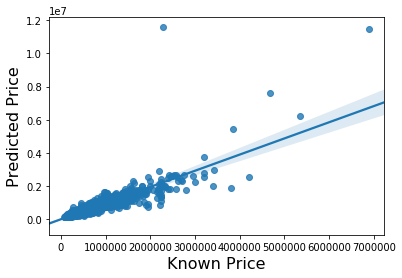

In [35]:
sns.regplot(np.exp(y_test), np.exp(y_predict))
plt.xlabel('Known Price', fontsize=16)
plt.ylabel('Predicted Price', fontsize=16)

In [37]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.8614207727254627
0.86553742250074


In [38]:
y_predict_train = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033479524944495194
Test Mean Squarred Error: 0.03329736169147085
0.9945589654176292


In [39]:
model_results = []
model_results.append(["Ridge - alpha .5", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [40]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
lasso.score(X_train, y_train)

0.0

In [42]:
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.2757884439286896
Test Mean Squarred Error: 0.03329736169147085
0.12073515922980631


In [45]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [46]:
alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)

In [47]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

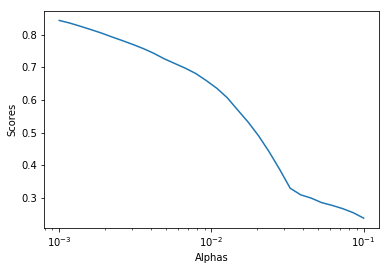

In [48]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [49]:
lasso = Lasso(alpha=.0001)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.8772270648002293

In [50]:
from sklearn.metrics import mean_squared_error
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.0338593567553026
Test Mean Squarred Error: 0.03329736169147085
0.9834020750041645


In [51]:
adj = r_adjusted(lasso.score(X_train, y_train), X_train, y_train)
model_results.append(["Lasso - alpha .0001", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [52]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [53]:

alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [54]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

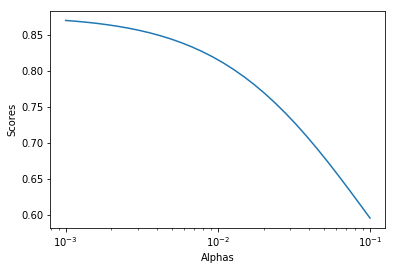

In [55]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [56]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033711309264609204
Test Mean Squarred Error: 0.03329736169147085
0.9877208099546307


In [58]:
elastic.score(X_train, y_train)

0.8777638802250688

In [59]:
L1_ratios = np.linspace(0, 1, 3)

tuned_parameters = [{'l1_ratio': L1_ratios}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [60]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'l1_ratio': array([0. , 0.5, 1. ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

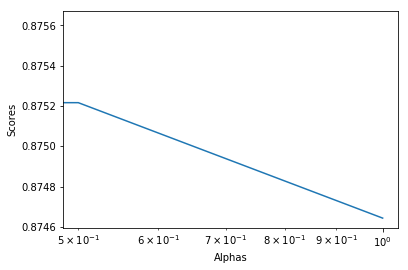

In [61]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(L1_ratios, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [62]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
elastic.score(X_train, y_train)

0.8781737076796576

In [64]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03359828358862892
Test Mean Squarred Error: 0.03329736169147085
0.9910435336268214


In [67]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="r2")

In [71]:
print(cvs.mean(),cvs.std())

0.8749011898002378 0.00967287129994385


In [70]:
# lasso.coef_

Printing out a list of the coefficients

In [73]:
# list(zip(lasso.coef_, X_train.columns))

In [75]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [76]:
coefs.sort(key=lambda x : x[0], reverse=True)
coefs[0:5]

[(1.2455739346607302, 'sqft_living'),
 (1.2056823466384468, 'lat'),
 (1.0806918481799308, 'sqft_above'),
 (0.8690733651705043, 'sqft_lot'),
 (0.5505731352029665, 'ZIP_98039')]

In [77]:
coefs = [x for x in coefs if "ZIP" in x[1]]

In [80]:
# coefs.sort(key=lambda x: x[0])

In [81]:
# coefs

In [82]:
adj = r_adjusted(elastic.score(X_train, y_train), X_train, y_train)
model_results.append(["Elastic - alpha=.0001, l1_ratio=.00001", elastic.score(X_train, y_train), adj, train_mse, test_mse])

In [83]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03359828358862892
Test Mean Squarred Error: 0.03329736169147085
0.9910435336268214


In [85]:
linreg.score(X_train, y_train)

0.8787146197951747

In [86]:
adj = r_adjusted(linreg.score(X_train, y_train), X_train, y_train)
adj

0.8779871335290964

In [87]:
model_results.append(["Linear Regression", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [89]:
print("Ratio of MSEs")
["%s - %s" % (x[0], x[3]/x[4]) for x in model_results]

Ratio of MSEs


['Ridge - alpha .5 - 1.0054708014019924',
 'Lasso - alpha .0001 - 1.0168780658671737',
 'Elastic - alpha=.0001, l1_ratio=.00001 - 1.0090374096286179',
 'Linear Regression - 1.0090374096286179']

# Model Comparison Plot

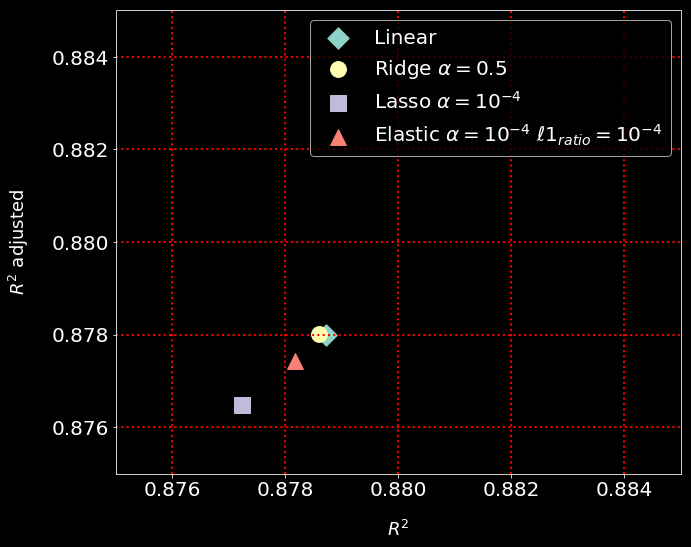

In [91]:
plt.style.use('dark_background')
plt.rc('text',usetex=False)
plt.rcParams.update({'font.size':20})
fig = plt.figure(figsize=(10,8))
plt.grid(color='r', linestyle=':', linewidth=2)

x = model_results[3][1]
y = model_results[3][2]
plt.scatter(x,y,marker = 'D', s=230, label = 'Linear')

x = model_results[0][1]
y = model_results[0][2]
plt.scatter(x,y, marker = 'o', s=250, label = r'Ridge $\alpha = 0.5$')

x = model_results[1][1]
y = model_results[1][2]
plt.scatter(x,y,marker = 's',s=250, label = r'Lasso $\alpha = 10^{-4}$')


x = model_results[2][1]
y = model_results[2][2]
plt.scatter(x,y,marker = '^', s=250, label = r'Elastic $\alpha = 10^{-4}$ $\ell1_{ratio}=10^{-4}$')
plt.legend(frameon=True)

plt.xlim([0.875,0.885])
plt.ylim([0.875,0.885])

plt.xlabel(r'$R^{2}$', fontsize=18,labelpad=20)
plt.ylabel(r'$R^{2}$ adjusted', fontsize=18,labelpad=20 )
plt.tight_layout()
plt.savefig('model-comparison.png')



## Interpreting the Model

In [92]:
zero_coefs = [x for x in coefs if x[0]==0]

In [93]:
for zero_coef in zero_coefs:
    print('Dropping parameter ' + zero_coef[1])
    X_train.drop(zero_coef[1], axis=1, inplace=True)
    X_test.drop(zero_coef[1], axis=1, inplace=True)

Dropping parameter ZIP_98022
Dropping parameter ZIP_98024


In [94]:
lasso_reduced = Lasso(alpha=.0001)
lasso_reduced.fit(X_train, y_train)
lasso_reduced.score(X_train, y_train)

0.8772307003492005

In [95]:
coefs_reduced = list(zip(lasso_reduced.coef_, X_train.columns))

In [99]:
for coef in coefs_reduced:
     if 'GRADE' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
        if int(gnum1)==3: continue
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'GRADE' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
#                 print(gnum2)
#                 continue
                if int(gnum2)>int(gnum1):
                
    #                 print(coef[1],'\t',coef2[1])
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
        # going to grade 13
        delta_y = -coef[0]
        price_change = (np.exp(delta_y)-1.0)*100
        print('changing from ', gnum1,' to 13 is {0:0.1f}%'.format(price_change))

changing from  4  to  5 is -7.2%
changing from  4  to  6 is 2.5%
changing from  4  to  7 is 16.2%
changing from  4  to  8 is 28.5%
changing from  4  to  9 is 42.5%
changing from  4  to  10 is 50.6%
changing from  4  to  11 is 52.9%
changing from  4  to  12 is 53.8%
changing from  4  to 13 is 33.3%
changing from  5  to  6 is 10.5%
changing from  5  to  7 is 25.3%
changing from  5  to  8 is 38.5%
changing from  5  to  9 is 53.5%
changing from  5  to  10 is 62.4%
changing from  5  to  11 is 64.8%
changing from  5  to  12 is 65.8%
changing from  5  to 13 is 43.7%
changing from  6  to  7 is 13.4%
changing from  6  to  8 is 25.4%
changing from  6  to  9 is 39.0%
changing from  6  to  10 is 47.0%
changing from  6  to  11 is 49.2%
changing from  6  to  12 is 50.1%
changing from  6  to 13 is 30.1%
changing from  7  to  8 is 10.6%
changing from  7  to  9 is 22.6%
changing from  7  to  10 is 29.6%
changing from  7  to  11 is 31.5%
changing from  7  to  12 is 32.3%
changing from  7  to 13 is 14.7%

In [97]:
coefs_reduced

[(-0.0037000265024937887, 'bedrooms'),
 (0.04343132032717252, 'bathrooms'),
 (1.247060795146874, 'sqft_living'),
 (0.8689811123190413, 'sqft_lot'),
 (-0.022905191059802536, 'floors'),
 (1.079586456995072, 'sqft_above'),
 (0.0, 'sqft_basement'),
 (-0.11259464991220051, 'yr_built'),
 (1.2037464116265162, 'lat'),
 (-0.38724989486344724, 'long'),
 (0.4740907770547238, 'sqft_living15'),
 (0.026037092296016202, 'sqft_lot15'),
 (0.06729982254272569, 'is_renovated'),
 (0.04593726925641741, 'has_basement'),
 (-0.25567955256846947, 'ZIP_98001'),
 (-0.2525556397360121, 'ZIP_98002'),
 (-0.2777658186950558, 'ZIP_98003'),
 (0.47058250008040803, 'ZIP_98004'),
 (0.11696962604769957, 'ZIP_98005'),
 (0.08870789682905186, 'ZIP_98006'),
 (0.0451206625914884, 'ZIP_98007'),
 (0.05200387029628387, 'ZIP_98008'),
 (0.06341389119736336, 'ZIP_98010'),
 (-0.33068133332789046, 'ZIP_98011'),
 (-0.20742942904771963, 'ZIP_98014'),
 (-0.31768683444197654, 'ZIP_98019'),
 (-0.33444501141657496, 'ZIP_98023'),
 (0.0492940

In [103]:
for coef in coefs_reduced:
     if 'VIEW' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'VIEW' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
#                 print(gnum2)
#                 continue
                if float(gnum2)>float(gnum1):
                
    #                 print(coef[1],'\t',coef2[1])
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
     # going to VIEW 4
        delta_y = -coef[0]
        price_change = (np.exp(delta_y)-1.0)*100
        print('changing from ', gnum1,' to ','4.0 is {0:0.1f}%'.format(price_change))


changing from  0.0  to  1.0 is 13.3%
changing from  0.0  to  2.0 is 11.6%
changing from  0.0  to  3.0 is 20.2%
changing from  0.0  to  4.0 is 30.3%
changing from  1.0  to  2.0 is -1.5%
changing from  1.0  to  3.0 is 6.1%
changing from  1.0  to  4.0 is 15.0%
changing from  2.0  to  3.0 is 7.7%
changing from  2.0  to  4.0 is 16.7%
changing from  3.0  to  4.0 is 8.4%


In [107]:
for coef in coefs_reduced:
     if 'COND' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'COND' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
                if float(gnum2)>float(gnum1):
                
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
#      going to COND 5
        delta_y = -coef[0]
        price_change = (np.exp(delta_y)-1.0)*100
        print('changing from ', gnum1,' to ','5 is {0:0.1f}%'.format(price_change))


changing from  1  to  2 is 8.4%
changing from  1  to  3 is 21.5%
changing from  1  to  4 is 27.5%
changing from  1  to  5 is 34.7%
changing from  2  to  3 is 12.1%
changing from  2  to  4 is 17.6%
changing from  2  to  5 is 24.3%
changing from  3  to  4 is 4.9%
changing from  3  to  5 is 10.9%
changing from  4  to  5 is 5.7%


In [106]:
# addet price if it has been renovated
for coef in coefs_reduced:
    if 'is_renovated' in coef[1]:
#         print(coef[0])
        delta_y = coef[0]
        price_change = (np.exp(delta_y)-1.0)*100
        print('Added price after renovating {0:0.1f}%'.format(price_change))

Added price after renovating 7.0%


For every 100 Sq. ft. added, the price goes up by 1.0%


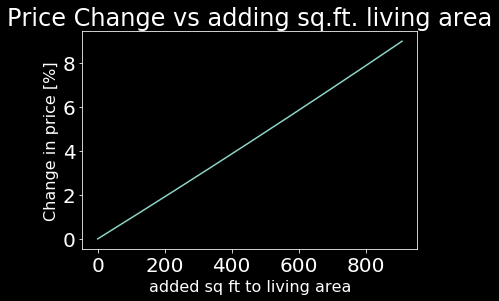

In [123]:
price_change = []
sqft = []
for i in range(370,1280):
    sqft.append(i-370)
    convert_one_sqft = (i-sqft_living_min)/sqft_living_range
    delta_per_price = (np.exp(coefs_reduced[2][0]*convert_one_sqft) - 1)
    price_change.append(delta_per_price*100)
    convert_one_sqft = (i-sqft_living_min)/sqft_living_range
#     price_change.append(convert_one_sqft)
plt.plot(sqft, price_change)
plt.xlabel("added sq ft to living area",fontsize=16)
plt.ylabel('Change in price [%]',fontsize=16)
plt.title('Price Change vs adding sq.ft. living area')
sqft_living_range-sqft_living_min

slope = (price_change[-1]-price_change[0])/(sqft[-1]-sqft[0])
print('For every 100 Sq. ft. added, the price goes up by {0:0.1f}%'.format(slope*100))

plt.savefig('Price Increase per Sq.ft.')


In [115]:
coefs_reduced[2][0]

1.247060795146874